[1.  0.5 0.  0.  0. ]
[1.  0.5 0.  0.  0. ]
[0.   0.75 1.   1.   1.  ]
[0.   0.75 1.   1.   1.  ]
[1.   0.25 0.   0.   0.  ]
[1.   0.25 0.   0.   0.  ]
[0.01002513 0.1026334  0.58578644 1.36754447 1.8       ]
[0.01002513 0.1026334  0.58578644 1.36754447 1.8       ]
[1.8        1.36754447 0.58578644 0.1026334  0.01002513]
[1.8        1.36754447 0.58578644 0.1026334  0.01002513]
(np.float64(0.6666666666666667), np.float64(0.22222222222222243), np.float64(0.5656854249492306), np.float64(-0.5999999999999694))
(np.float64(0.6666666666666666), np.float64(0.2222222222222222), np.float64(0.565685424949238), np.float64(-0.6000000000000001))
0.49999999999999983
0.5
25.0
shape > -1 does not hold
-20.0
[ 418.58899201  440.00217763  464.27607288  484.75892676  506.31579784
  525.48941849  562.66049068  590.09277599  629.90494282  685.50384415
  736.48619201  817.96296265  906.25723079 1033.62566411 1066.63326513
 1241.38903651 1426.95388339 1872.75922624  210.69896517    0.        ]
[ 115.80923845 

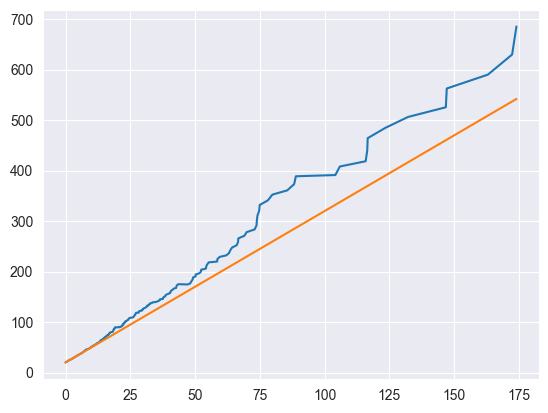

In [4]:
from torch.utils.data import DataLoader, random_split
from src.data.dataLoader import StructuralBreakDataLoader
from src.data.sliding_window_dataset import create_dataset_for_training, create_dataset_for_testing

from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn

In [5]:
import torch
from torch.utils.data import Dataset
from typing import Dict, Tuple


class SlidingWindowDataset(Dataset):
    """PyTorch Dataset for sliding window structural break detection"""

    def __init__(self, test_data_dict: Dict, window_size: int = 100):
        self.data, self.labels = self.create_data_tensor(test_data_dict, window_size)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

    def create_data_tensor(
        self,
        test_data_dict: Dict,
        window_size: int = 100,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        
        len_data = len(test_data_dict)
        data = torch.empty(size=(len_data, window_size))
        labels = torch.empty(size=(len_data,))

        i = 0
        for series_id, ts_obj in test_data_dict.items():
            len_pre_post = window_size // 2

            data[i, :len_pre_post] = torch.from_numpy(ts_obj.period_0_values[-len_pre_post:]).float()
            data[i, len_pre_post:] = torch.from_numpy(ts_obj.period_1_values[:len_pre_post]).float()
            
            labels[i] = torch.tensor(ts_obj.has_break, dtype=torch.float32)
            i += 1

        return data, labels

In [50]:
window_size = 128

In [51]:
from torch.utils.data import DataLoader

# Load data
data_handler = StructuralBreakDataLoader()
data_handler.load_data(use_crunch=False)

# Split into train and test dicts
train_dict, test_dict = data_handler.create_train_val_split(0.2)

# Create datasets
train_dataset = SlidingWindowDataset(train_dict, window_size=window_size)
test_dataset = SlidingWindowDataset(test_dict, window_size=window_size)

INFO:src.data.dataLoader:Data loaded successfully from local files


In [52]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, num_layers, noise=0.0, dropout_prob=0.0):
        """
        Parameters:
        - input_size: Number of input features.
        - hidden_dim: Dimension of the hidden layers.
        - output_size: Number of output features.
        - use_noise: Whether to apply Gaussian noise to the input.
        - dropout_prob: Dropout probability. Set to 0.0 to disable dropout.
        - num_hidden_layers: Number of fully connected hidden layers.
        """
        super(SimpleNN, self).__init__()

        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.output_size = output_size

        self.dropout_prob = dropout_prob

        # Define layers dynamically using nn.Sequential
        layers = []

        # layers.append(GaussianNoise(std=noise))

        # Input layer
        layers.append(nn.Linear(self.input_size, hidden_dim))
        layers.append(nn.ReLU())

        # Add additional hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))

        # Output layer
        layers.append(nn.Linear(hidden_dim, output_size))

        # Combine into a Sequential module
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential layers
        out = self.network(x)
        return out


In [11]:
class StructuralBreakCNN(nn.Module):
    def __init__(self, input_size, num_filters=64, kernel_sizes=[3], 
                 hidden_dim=128, dropout_prob=0.2, output_size=1):
        """
        CNN for structural break detection in time series
        
        Parameters:
        - input_size: Length of input sequence (window_size)
        - num_filters: Number of filters per convolutional layer
        - kernel_sizes: List of kernel sizes for different conv layers
        - hidden_dim: Dimension of fully connected layers
        - dropout_prob: Dropout probability
        - output_size: Number of output features (1 for binary classification)
        """
        super(StructuralBreakCNN, self).__init__()
        
        self.input_size = input_size
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes
        
        # Convolutional layers with different kernel sizes
        self.conv_layers = nn.ModuleList()
        for kernel_size in kernel_sizes:
            conv_block = nn.Sequential(
                nn.Conv1d(in_channels=1, out_channels=num_filters, 
                         kernel_size=kernel_size, padding=kernel_size//2),
                nn.BatchNorm1d(num_filters),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2, stride=2),
                nn.Dropout(dropout_prob)
            )
            self.conv_layers.append(conv_block)
        
        # Calculate the size after convolutions and pooling
        # After each MaxPool1d with kernel_size=2, length is roughly halved
        conv_output_size = (input_size // 2) * num_filters * len(kernel_sizes)
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(conv_output_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim // 2, output_size)
        )
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length)
        # Reshape for Conv1d: (batch_size, channels, sequence_length)
        x = x.unsqueeze(1)  # (batch_size, 1, sequence_length)
        
        # Apply multiple convolutional branches
        conv_outputs = []
        for conv_layer in self.conv_layers:
            conv_out = conv_layer(x)  # (batch_size, num_filters, reduced_length)
            conv_outputs.append(conv_out)
        
        # Concatenate outputs from different kernel sizes
        x = torch.cat(conv_outputs, dim=1)  # (batch_size, num_filters*len(kernel_sizes), reduced_length)
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)  # (batch_size, flattened_features)
        
        # Apply fully connected layers
        x = self.fc_layers(x)
        
        return x

In [47]:
from torch import Tensor
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class StandardTransformer(nn.Module):
    def __init__(self, input_size, d_model=128, nhead=8, num_layers=4, 
                 dim_feedforward=512, dropout_prob=0.1, output_size=1):
        """
        Standard Transformer for structural break detection
        
        Parameters:
        - input_size: Length of input sequence (window_size)
        - d_model: Dimension of model embeddings
        - nhead: Number of attention heads
        - num_layers: Number of transformer layers
        - dim_feedforward: Dimension of feedforward network
        - dropout_prob: Dropout probability
        - output_size: Number of output features (1 for binary classification)
        """
        super(StandardTransformer, self).__init__()
        
        self.d_model = d_model
        self.input_size = input_size
        
        # Input projection layer (1 feature -> d_model)
        self.input_projection = nn.Conv1d(in_channels=2, out_channels=d_model, kernel_size=3, padding=1, stride=1)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout_prob, max_len=input_size)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout_prob,
            activation='relu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(d_model // 2, output_size)
        )
        
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, x):
        # Handle different input shapes
        if len(x.shape) == 2:
            # x shape: (batch_size, window_size) -> add channel dimension
            x = x.unsqueeze(1)  # (batch_size, 1, window_size)
        
        b, c, s = x.shape
        zz = torch.zeros((b, c, s))
        sp = s // 2
        zz[:, :, -sp:] = torch.ones((b, c, sp))
        
        x = torch.cat((x, zz), dim=1)
        
        x = self.input_projection(x)  # (batch_size, d_model, window_size // 2)
        
        # Add positional encoding
        x = self.pos_encoder(x.permute(2, 0, 1)).permute(1, 0, 2)  # (batch_size, window_size, d_model)
        
        # Apply dropout
        x = self.dropout(x)
        
        # Apply transformer
        x = self.transformer_encoder(x)  # (batch_size, window_size, d_model)
        
        # Global average pooling or use [CLS] token approach
        # Here we use global average pooling
        x = x[:, -1, :] # (batch_size, d_model)
        # x = torch.mean(x, dim=1)  # (batch_size, d_model)
        
        # Classification
        x = self.classifier(x)  # (batch_size, output_size)
        
        return x

In [53]:
from tqdm import tqdm

model   = SimpleNN(input_size=window_size, hidden_dim=64, output_size=1,
                   num_layers=2, noise=0.0, dropout_prob=0.0)
model = StructuralBreakCNN(
    input_size=window_size, 
    num_filters=64,
    kernel_sizes=[3],  # Multi-scale feature extraction
    hidden_dim=128,
    dropout_prob=0.2,
    output_size=1
)
model = StructuralBreakLSTM()

# model = StandardTransformer(
#         input_size=window_size,
#         d_model=64,
#         nhead=2,
#         num_layers=4,
#         dropout_prob=0.2,
#         output_size=1
#     )

print(sum(p.numel() for p in model.parameters() if p.requires_grad))

loss_fct = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)

for epoch in range(20):
    # ---- TRAINING ----
    model.train()
    total_loss = 0.0
    for X, y in tqdm(train_loader):

        optimizer.zero_grad()          # reset grads
        logits = model(X)              # forward
        loss   = loss_fct(logits.squeeze(), y.squeeze())
        loss.backward()                # backward
        optimizer.step()               # update params

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    
    # ---- EVALUATION ----
    model.eval()
    y_trues, y_scores = [], []
    with torch.no_grad():
        for X, y in test_loader:
            logits = model(X)

            # collect
            y_trues.append(y.view(-1).cpu())
            y_scores.append(logits.view(-1).cpu())
    
    # concatenate everything
    y_true  = torch.cat(y_trues).numpy()
    y_score = torch.cat(y_scores).numpy()
    roc_auc = roc_auc_score(y_true, y_score)

    print(f"Epoch {epoch+1:2d} — Train loss: {avg_train_loss:.4f}    ROC-AUC: {roc_auc:.4f}")


144001


100%|██████████| 126/126 [01:00<00:00,  2.08it/s]


Epoch  1 — Train loss: 0.6105    ROC-AUC: 0.4972


100%|██████████| 126/126 [01:00<00:00,  2.08it/s]


Epoch  2 — Train loss: 0.6049    ROC-AUC: 0.4947


100%|██████████| 126/126 [01:09<00:00,  1.82it/s]


Epoch  3 — Train loss: 0.6039    ROC-AUC: 0.4973


 71%|███████▏  | 90/126 [00:44<00:17,  2.01it/s]


KeyboardInterrupt: 

In [48]:
class StructuralBreakLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, 
                 dropout_prob=0.1, output_size=1, bidirectional=True):
        """
        LSTM for structural break detection
        
        Parameters:
        - input_size: Number of input features per timestep (1 for univariate)
        - hidden_size: Number of hidden units in LSTM
        - num_layers: Number of LSTM layers
        - dropout_prob: Dropout probability
        - output_size: Number of outputs (1 for binary classification)
        - bidirectional: Whether to use bidirectional LSTM
        """
        super(StructuralBreakLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout_prob if num_layers > 1 else 0,
            batch_first=True,
            bidirectional=bidirectional
        )
        
        # Output dimensions after LSTM
        lstm_output_size = hidden_size * self.num_directions
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size, lstm_output_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(lstm_output_size // 2, lstm_output_size // 4),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(lstm_output_size // 4, output_size)
        )
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize LSTM and linear layer weights"""
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
                # Set forget gate bias to 1
                n = param.size(0)
                start, end = n // 4, n // 2
                param.data[start:end].fill_(1.0)
        
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)
    
    def forward(self, x):
        batch_size, seq_len = x.size()
        
        # Reshape input: (batch_size, seq_len) -> (batch_size, seq_len, input_size)
        if len(x.shape) == 2:
            x = x.unsqueeze(-1)
        
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, 
                        self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers * self.num_directions, batch_size, 
                        self.hidden_size, device=x.device)
        
        # LSTM forward pass
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
        # lstm_out shape: (batch_size, seq_len, hidden_size * num_directions)
        
        # Use the last timestep output for classification
        # For bidirectional LSTM, this combines forward and backward final states
        final_output = lstm_out[:, -1, :]  # (batch_size, hidden_size * num_directions)
        
        # Classification
        output = self.classifier(final_output)  # (batch_size, output_size)
        
        return output